In [6]:
# Imports (External)
import numpy as np
import pandas as pd
import datetime as dt
import xlrd
import xlsxwriter
from collections import OrderedDict
import copy

import sys
sys.path.append('../')  

# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

import pywt
from pywt import wavedec, waverec
from scipy import signal
from statsmodels.robust import mad

# Internal Imports
from wsae_lstm.utils import pickle_load,pickle_save
#from wsae_lstm.models.wavelet import waveletSmooth

In [14]:
dict_dataframes_index=pickle_load(path_filename="../data/interim/cdii_tvt_split.pickle")
ddi_scaled=pickle_load(path_filename="../data/interim/cdii_tvt_split_scaled.pickle")
#ddi_denoised2=pickle_load(path_filename="../data/interim/cdii_tvt_split_scaled_denoised.pickle")

In [15]:
ddi_scaled.keys()

dict_keys(['csi300 index data', 'nifty 50 index data', 'hangseng index data', 'nikkei 225 index data', 's&p500 index data', 'djia index data'])

In [16]:
dict_dataframes_index['nifty 50 index data'][1][1].head(1)

,open,high,low,close,volume,macd,cci,atr,boll_mid,ema20,ma5,ma10,mtm6,mtm12,roc,smi,wvad,us dollar index,interbank offered rate
date,,,,,,,,,,,,,,,,,,,
2008-07-01,4039.75,4075.4,3878.2,3896.75,164469220,-201.56,-180.03,197.2,4409.04,4385.058946,4128.49,4253.415,-369.65,-620.35,-13.733369,-0.149627,-828023961.0,72.34,8.706


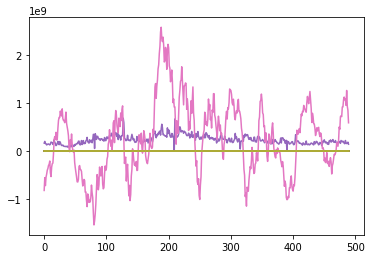

In [17]:
plt.plot(dict_dataframes_index['nifty 50 index data'][1][1].values);

In [52]:

def waveletSmooth( x, wavelet="haar", level=2, declevel=2):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode='periodization',level=declevel,axis=0 )
    # calculate a threshold
    sigma = mad(coeff[-level])
    print("sigma: ",sigma)
    print("sigma: ",sigma[1:])
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    print("uthresh: ",uthresh)
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="hard" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode='periodization',axis=0 )
    return y

In [53]:
pd.DataFrame(waveletSmooth(ddi_scaled['nifty 50 index data'][1][1])).head(1)

sigma:  [0.04939658 0.04550829 0.04832723 0.05920866 0.36142095 0.18226018
 0.3081891  0.51315239 0.02199135 0.02186411 0.03792052 0.03081983
 0.5377685  0.34072106 0.32099246 0.42394007 0.26288589 0.08262499
 0.0135089 ]
sigma:  [0.04550829 0.04832723 0.05920866 0.36142095 0.18226018 0.3081891
 0.51315239 0.02199135 0.02186411 0.03792052 0.03081983 0.5377685
 0.34072106 0.32099246 0.42394007 0.26288589 0.08262499 0.0135089 ]
uthresh:  [0.17386483 0.1601789  0.17010093 0.20840113 1.27212016 0.64151467
 1.08475606 1.80618057 0.0774046  0.07695675 0.13347165 0.10847885
 1.89282374 1.1992612  1.12982101 1.49217335 0.92529898 0.29082132
 0.04754829]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.302081,-0.294161,-0.322845,-0.306605,-0.44357,-2.040011,-0.961938,1.709341,-0.032972,-0.026006,-0.261274,-0.173347,-1.275034,-1.668555,-1.576125,-1.603616,-0.871277,-1.105886,2.326196


In [54]:
len(ddi_scaled['nifty 50 index data'][1][2])

66

In [38]:
len(waveletSmooth(ddi_scaled['nifty 50 index data'][1][2]))

sigma:  19
sigma:  18
uthresh:  [0.09416314 0.08664319 0.07353517 0.06576805 0.63240886 0.13690483
 0.93819233 0.54184221 0.02145531 0.01985772 0.05109739 0.02591177
 0.63674184 0.51245768 0.40043987 0.43463081 0.29621927 0.17639147
 0.23462565]


66

In [29]:
pd.DataFrame(waveletSmooth(ddi_scaled['nifty 50 index data'][1][2])).head(1)

sigma:  [0.03252946 0.02993163 0.02540335 0.02272013 0.21847102 0.04729494
 0.32410651 0.187184   0.00741192 0.00686002 0.01765203 0.00895144
 0.21996788 0.17703286 0.13833536 0.15014691 0.10233146 0.06093593
 0.08105342]
uthresh:  [0.09416314 0.08664319 0.07353517 0.06576805 0.63240886 0.13690483
 0.93819233 0.54184221 0.02145531 0.01985772 0.05109739 0.02591177
 0.63674184 0.51245768 0.40043987 0.43463081 0.29621927 0.17639147
 0.23462565]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.476825,0.470692,0.500779,0.472125,-0.798272,0.241742,-0.048743,-0.614159,0.513918,0.526117,0.481439,0.50993,-0.370022,-0.105744,-0.118906,-0.288212,0.343153,0.557645,0.993394


In [30]:
pd.DataFrame(waveletSmooth(ddi_scaled['nifty 50 index data'][1][3])).head(1)

sigma:  [0.05526143 0.0657368  0.06952674 0.06134436 0.22678124 0.15162596
 0.53210228 0.37495112 0.01578969 0.01036554 0.03005296 0.0211213
 0.44889338 0.27078156 0.18138578 0.19567746 0.17285944 0.10534687
 0.10469401]
uthresh:  [0.15937695 0.18958848 0.20051886 0.17692042 0.6540493  0.43729741
 1.53461159 1.0813792  0.04553831 0.02989478 0.08667436 0.06091496
 1.29463264 0.78094857 0.52312634 0.56434431 0.49853592 0.30382603
 0.30194314]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.005642,1.048609,1.036944,1.027124,-0.464185,1.162558,0.44609,-0.123304,0.946069,0.951874,0.98042,0.972389,0.496795,0.58049,0.379222,0.304462,1.210551,-0.339951,1.140091


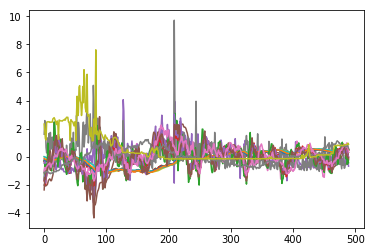

In [317]:
plt.plot(ddi_scaled['nifty 50 index data'][1][1].values);

In [318]:
def denoise_periods(dict_dataframes):
    ddi_denoised= dict() 
    for key, index_name in enumerate(dict_dataframes):
        ddi_denoised[index_name] = copy.deepcopy(dict_dataframes[index_name])
    for key, index_name in enumerate(ddi_denoised): 
        for index,value in enumerate(ddi_denoised[index_name]):
            
            X_train_scaled = ddi_denoised[index_name][value][1]
            X_val_scaled = ddi_denoised[index_name][value][2]
            X_test_scaled = ddi_denoised[index_name][value][3]
                                                          
            ddi_denoised[index_name][value][1] = waveletSmooth(X_train_scaled)
            ddi_denoised[index_name][value][2] = waveletSmooth(X_val_scaled)
            ddi_denoised[index_name][value][3] = waveletSmooth(X_test_scaled)
            
    return ddi_denoised

In [319]:
ddi_denoised = denoise_periods(ddi_scaled)

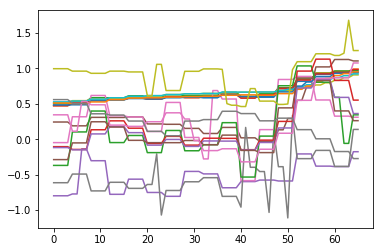

In [320]:
plt.plot(ddi_denoised['nifty 50 index data'][1][2]);

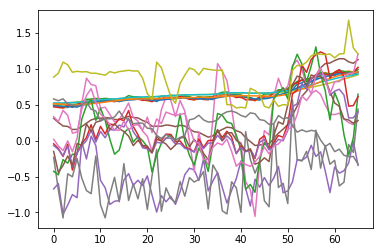

In [321]:
plt.plot(ddi_scaled['nifty 50 index data'][1][2]);

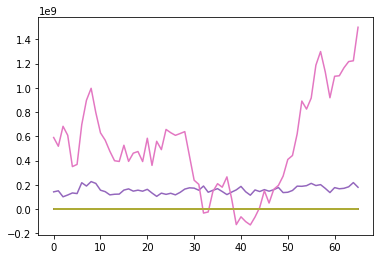

In [322]:
plt.plot(dict_dataframes_index['nifty 50 index data'][1][2].values);

In [323]:
#plt.plot(scaler.inverse_transform(X_train_scaled));

In [324]:
ddi_scaled['nifty 50 index data'][1][2].columns

Index(['open', 'high', 'low', 'close', 'volume', 'macd', 'cci', 'atr',
       'boll_mid', 'ema20', 'ma5', 'ma10', 'mtm6', 'mtm12', 'roc', 'smi',
       'wvad', 'us dollar index', 'interbank offered rate'],
      dtype='object')

In [325]:
# from colorsys import hls_to_rgb
# import numpy as np 

# def get_distinct_colors(n):

#     colors = []

#     for i in np.arange(0., 360., 360. / n):
#         h = i / 360.
#         l = (50 + np.random.rand() * 10) / 100.
#         s = (90 + np.random.rand() * 10) / 100.
#         colors.append(hls_to_rgb(h, l, s))

#     return colors

In [326]:
# list(get_distinct_colors(20))

In [327]:
# import seaborn as sns
# colors = sns.color_palette("hls", 20)
# sns.palplot(colors)
# colors = sns.color_palette("Set2", 20)
# sns.palplot(colors)


In [328]:
#sns.palplot(sns.color_palette("Paired",19))

In [361]:
type(plt.cm.tab20)

matplotlib.colors.ListedColormap

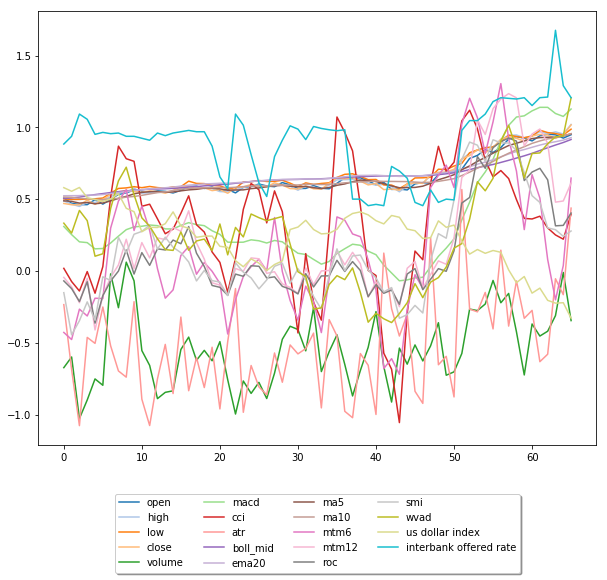

In [359]:
f, ax = plt.subplots(figsize= (10,8))


colormap = plt.cm.tab20
colors = [colormap(i) for i in np.linspace(0, 1,20)]
ax.set_prop_cycle('color', colors)
#plt.set_cmap('tab20c')
ax.plot(ddi_scaled['nifty 50 index data'][1][2])
plt.legend(ddi_scaled['nifty 50 index data'][1][2].columns,loc='upper center',bbox_to_anchor=(0.5, -0.1),
           ncol=4,fancybox=True,shadow=True)
plt.show()